# Question 1.c

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

torch.set_printoptions(precision=10)
torch.__version__

'0.3.1.post2'

## Load train and test dataset

In [2]:
class OccupancyDataset(Dataset):
    """ Occupancy detection dataset"""
    
    def __init__(self, filename):
        self.dataset = np.loadtxt(filename, skiprows=1, dtype = object, delimiter=',')
        
        self.data = np.array(self.dataset[:,2:7], dtype = float)
        self.data = (self.data - self.data.mean())/self.data.std()
        self.data = torch.from_numpy(self.data).float()
        
        self.target = np.array(self.dataset[:,7], dtype = float)
        self.target = torch.from_numpy(self.target).float()
        
    def __len__(self):
        return self.data.size()[0]
    
    def __getitem__(self, idx):
        return (self.data[idx, :], self.target[idx])

    
# Setup datasets and loaders
train_dataset = OccupancyDataset('train_data.txt')
test_dataset = OccupancyDataset('test_data.txt')

train_batch_size = 100
test_batch_size = 100

train_loader = DataLoader(train_dataset, batch_size = train_batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size= test_batch_size, shuffle = False)

## Create network class

In [3]:
class Net(nn.Module):
    """ Neural network with 1 hidden layer and sigmoid activations """
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(5,5)
        self.fc2 = nn.Linear(5,1)
        
    def forward(self, x):
        #print(x)
        x = F.sigmoid(self.fc1(x))
        return F.sigmoid(self.fc2(x))
    
n = Net()
print(n)
#print(list( n.parameters()) )

Net(
  (fc1): Linear(in_features=5, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)


## Setting variables

In [4]:
net = Net()
print(list(net.parameters()))
epochs = 2000
lr = 0.001
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
criterion = nn.BCELoss()

[Parameter containing:
0.1375858188 -0.2649408281 -0.4097303450 -0.1729954183 -0.1228315830
-0.2421568632 0.3503617644 0.0933097005 -0.3012712598 -0.2139696926
-0.1036989987 -0.2980346382 -0.1214510202 0.1840012074 0.4101661444
-0.0150365531 0.0649058819 0.2682735920 -0.2381616682 -0.2311115265
-0.2867064476 0.3596637249 -0.0094849467 -0.2895666063 0.2844118476
[torch.FloatTensor of size 5x5]
, Parameter containing:
0.1502001286
-0.0486098826
-0.1433329284
-0.1370777190
-0.0223564506
[torch.FloatTensor of size 5]
, Parameter containing:
-0.1548205018 -0.0772991180 0.1621451974 -0.3623195887 0.3792951107
[torch.FloatTensor of size 1x5]
, Parameter containing:
0.2953833342
[torch.FloatTensor of size 1]
]


## Train function

In [5]:
def train(epoch):
    # Train the network
    running_loss = 0
    count = 0
    for i, data in enumerate(train_loader, 0):
        optimizer.zero_grad()
        inputs, target = data
        inputs, target = Variable(inputs), Variable(target.float())
        output = net(inputs).squeeze()
        loss =  criterion(output, target)     
        loss.backward()
        optimizer.step()
        running_loss += loss.data[0]
        count +=1

    return running_loss/count
    
    
def get_acc(loader, dataset):
    # Get accuracy (%) for train/test
    correct = 0
    total = 0
    for i, data in enumerate(loader, 0):
        inputs, target = data
        inputs, target = Variable(inputs), Variable(target.float())
        output = net(inputs).squeeze()
        output = output>0.5
        correct += (target.data.cpu().numpy() == output.data.cpu().numpy()).sum()
        total += target.size(0)
    return 100*int(correct)/int(total)
    

In [6]:
losses = []
errors = []
final_epoch = 0

# Run epochs and store necessary metrics
for i in range(epochs):
    loss = train(i)
    losses.append(loss)
    train_acc = get_acc(train_loader, 'Train')
    errors.append(100-train_acc)
    test_acc = get_acc(test_loader, 'Test')
    if i%100==0:
        print('\n')
        print('Loss after epoch {1}: {0}'.format(loss, i))
        print('Train Accuracy: {0}'.format(train_acc))
        print('Test Accuracy: {0}'.format(test_acc))
        
        # Stop training based on below condition
    if i>200 and errors[i-50]-errors[i] < 1e-2:
        print('Reached local minima at epoch: {0} with error: {1}'.format(i, errors[i]))
        final_epoch = i
        break
            




Loss after epoch 0: 0.7053903072345548
Train Accuracy: 78.76703917475132
Test Accuracy: 78.98892534864643


Loss after epoch 100: 0.10930645995114635
Train Accuracy: 98.82107331450325
Test Accuracy: 96.70836751435603


Loss after epoch 200: 0.06999576451234156
Train Accuracy: 98.83335380081051
Test Accuracy: 98.87202625102543
Reached local minima at epoch: 201 with error: 1.1666461991894863


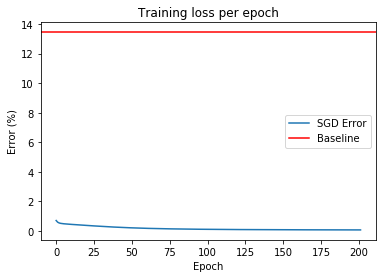

In [8]:
# Plot training error
plt.figure()
plt.title('Training loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Error (%)')
plt.plot(range(final_epoch+1), losses, label = 'SGD Error')

# Plot baseline BCE error 13.447936
plt.axhline(y=13.447936, color='r', linestyle='-', label = 'Baseline')
plt.legend()
#plt.plot( range)


### Observations:

    - Learning rate used was 0.001 with momentum = 0.9
    - Final results 
        - Train Accuracy: 98.83335380081051
        - Test Accuracy: 98.87202625102543
    - Training was stopped on condition that epochs>200 and error decrease in previous 50 epochs less than 1e-2